# Tutorial 2 - Moran's I

Demo data for the tutorial can be downloaded from [Zenodo](https://doi.org/10.5281/zenodo.16740333)

In [1]:
import numpy as np
import seaborn as sns 
from matplotlib import pyplot as plt

import SplIsoFind

## Construct isoform matrix with relative expression

The create isoform matrix saves a sparse matrix, and corresponding index and column labels to the output folder. 

NOTE: this is the same step as we do before plotting the results, you only have to do this once

In [2]:
fn_allinfo = 'data/allinfo_ds.filtered.labeled.gz'
fn_CIDmap = 'data/sample1_barcodeToPos.CellID_ds.tsv.gz'
fn_adata = 'data/sample1_cellbin_adjusted.h5ad'
output = 'data/isoform_matrix'

SplIsoFind.pp.create_isoform_matrix(fn_allinfo,
                                            fn_CIDmap,
                                            fn_adata,
                                            output)

Potentially interesting isoforms (total): 145
Potentially interesting isoforms (novel): 44


  0%|          | 0/198 [00:00<?, ?it/s]

In [3]:
x, labels = SplIsoFind.pp.sparse2df(input_dir = output)

## Calculate Moran's I 

For all cells ('All') and for the four major cell types. 

The running time mainly depends on the number of cells, number of tested isoforms, and number of permutations. Doing 1e6 permutations will take ~10min for this demo dataset.

The moran's I function returns 2 dataframes: 
- pval: the uncorrected p-values 
- qval: Benjamini-Yekutieli corrected values

NaN indicates that a specific isoform-celltype combination did not fulfill the testing criteria (e.g. not enough cells).

In [4]:
mI_scores, pval, qval = SplIsoFind.sv.moransI(x=x,
                                labels=labels, 
                                celltypes=['All','ExciteNeuron','InhibNeuron','Astro','Oligo'],
                                output_dir='data/moransI')

  0%|          | 0/145 [00:00<?, ?it/s]

Number of significant isoforms per celltype

In [5]:
(qval <= 0.05).sum()

All             17
ExciteNeuron     7
InhibNeuron      2
Astro            2
Oligo            0
dtype: int64

## Cell-type constrained permutations

For the significant isoforms using all cells, we run Moran's I with cell-type constrained permutations. This way we can check whether significance is caused by one or more cell types causing splicing changes (p-value will still be significant) or because of different cell-type proportions between the regions (p-value won't be significant anymore).

This function is significantly slower, so we only run it on the significant isoforms. This will take ~1h to run on the demo dataset.

In [6]:
iso_sign = qval.index[qval['All'] <= 0.05]

In [7]:
iso_sign[:1]

Index(['ENSMUST00000051477.13'], dtype='object')

In [8]:
res = SplIsoFind.sv.moransI_ctperm(x=x, 
                     labels=labels, 
                     variables=iso_sign,
                     output_dir='data/moransI')

  0%|          | 0/17 [00:00<?, ?it/s]

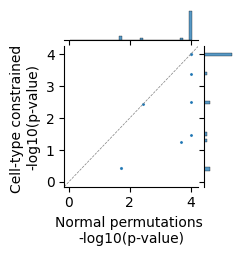

In [9]:
g = sns.jointplot(
    x=-np.log10(res['p-value (original)']),
    y=-np.log10(res['p-value (new)']),
    marginal_kws={"binwidth": 0.1, "binrange": [0.05, 4.05]},
    height=2.5, s=5,
    ratio=4
)

# Add x = y line
lims = [
    np.min([g.ax_joint.get_xlim(), g.ax_joint.get_ylim()]),  # min of both axes
    np.max([g.ax_joint.get_xlim(), g.ax_joint.get_ylim()])   # max of both axes
]
g.ax_joint.plot(lims, lims, '--', color='gray', linewidth=0.5)  # diagonal line
g.ax_joint.set_xlim(lims)
g.ax_joint.set_ylim(lims)

# Set axis labels
g.set_axis_labels('Normal permutations \n-log10(p-value)',
                  'Cell-type constrained \n-log10(p-value)')
plt.show()

For most isoforms, the p-value of the normal and cell-type constrained permutations are very similar. For some, however, we see a big difference. Let's plot an example of both.

In [10]:
res.sort_values('p-value (new)')

,morans I,p-value (original),p-value (new),Num cells,Imbalance
ENSMUST00000121334.8,0.264462,0.000100,0.000100,989.0,0.407482
ENSMUST00000120878.9,0.259450,0.000100,0.000100,989.0,0.608696
transcript5764.chr18.nnic,0.118363,0.000100,0.000100,2061.0,0.737021
ENSMUST00000234496.2,0.171387,0.000100,0.000100,2061.0,0.658903
ENSMUST00000211044.2,0.148693,0.000100,0.000100,9937.0,0.721143
ENSMUST00000110098.4,0.054510,0.000100,0.000100,9762.0,0.907191
ENSMUST00000028727.11,0.054510,0.000100,0.000100,9762.0,0.070580
ENSMUST00000211283.2,0.171084,0.000100,0.000100,9937.0,0.322029
ENSMUST00000107745.8,0.069795,0.000100,0.000100,769.0,0.585176
ENSMUST00000075316.10,0.077535,0.000100,0.000100,769.0,0.568270


In [11]:
from PIL import Image
Image.MAX_IMAGE_PIXELS = 553190400

im_reg = Image.open('data/Sample1_ssDNA_regist.tif')
imarray = np.array(im_reg)

In [12]:
xlim1=5000
xlim2=17000
ylim1=4450
ylim2=18000

For example, within Snap25 has the lowest p-value possible using both normal and cell-type constrained permutations and we see spatial variation within excitatory and inhibitory neurons

In [13]:
isoform = 'ENSMUST00000028727.11'

res.loc[isoform]

morans I                 0.05451
p-value (original)       0.00010
p-value (new)            0.00010
Num cells             9762.00000
Imbalance                0.07058
Name: ENSMUST00000028727.11, dtype: float64

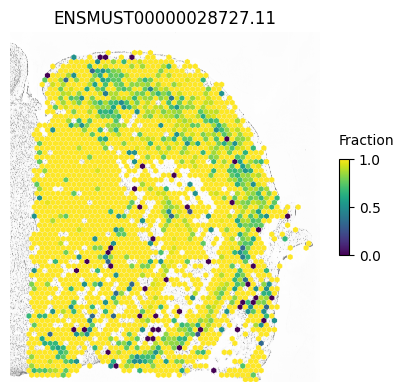

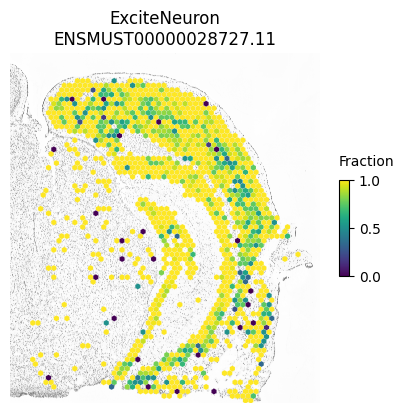

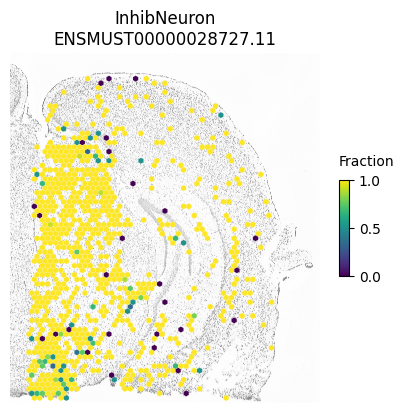

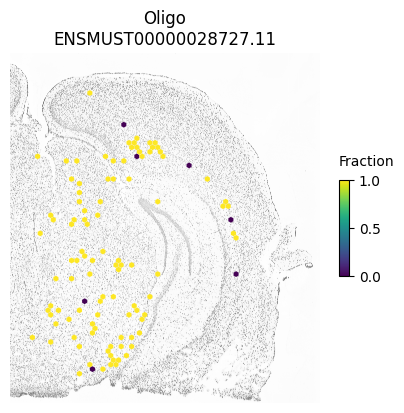

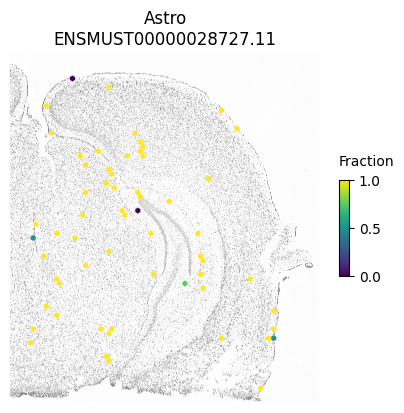

In [14]:
SplIsoFind.pl.spatial_hexplot(x=x, 
                labels=labels, 
                imarray=imarray,
                varName=isoform, 
                celltype='', 
                hexsize=350,
                plot_lim=[xlim1, xlim2, ylim1, ylim2])
plt.show()

for ct in ['ExciteNeuron', 'InhibNeuron', 'Oligo', 'Astro']:
    SplIsoFind.pl.spatial_hexplot(x=x, 
                    labels=labels, 
                    imarray=imarray,
                    varName=isoform, 
                    celltype=ct, 
                    hexsize=350,
                    plot_lim=[xlim1, xlim2, ylim1, ylim2])
    plt.show()


A counter example is an isoform of Apbb1. The spatial pattern using all cells is just caused by differences between excitatory neurons (which show some expression of this isoform) compared to the other cell types.

In [15]:
isoform = 'ENSMUST00000188368.7'

res.loc[isoform]

morans I                 0.031533
p-value (original)       0.000100
p-value (new)            0.003100
Num cells             3459.000000
Imbalance                0.908066
Name: ENSMUST00000188368.7, dtype: float64

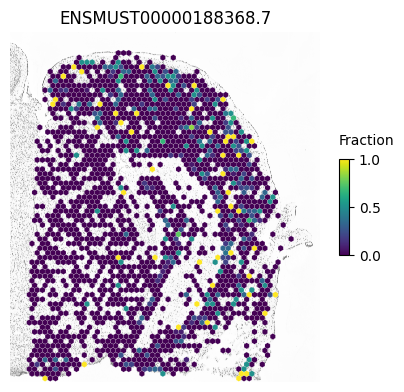

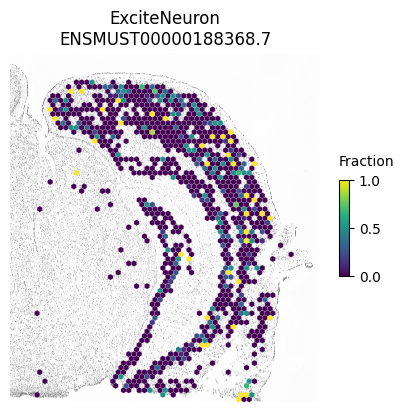

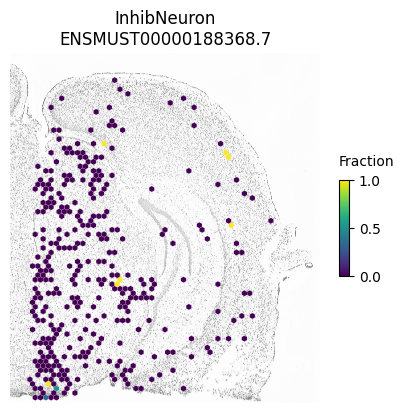

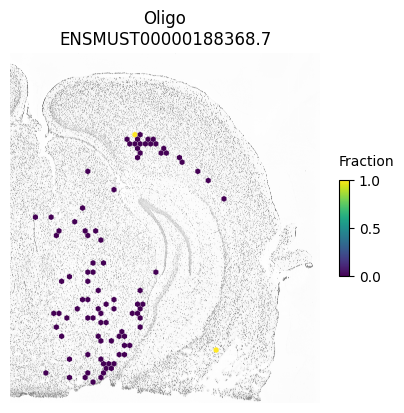

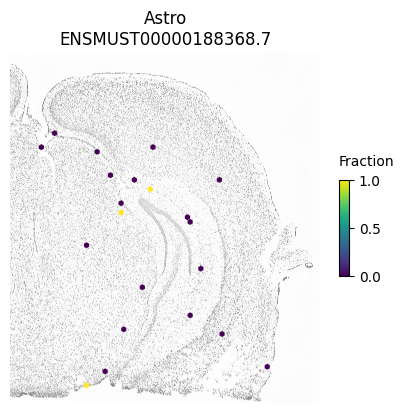

In [16]:
SplIsoFind.pl.spatial_hexplot(x=x, 
                labels=labels, 
                imarray=imarray,
                varName=isoform, 
                celltype='', 
                hexsize=350,
                plot_lim=[xlim1, xlim2, ylim1, ylim2])
plt.show()

for ct in ['ExciteNeuron', 'InhibNeuron', 'Oligo', 'Astro']:
    SplIsoFind.pl.spatial_hexplot(x=x, 
                    labels=labels, 
                    imarray=imarray,
                    varName=isoform, 
                    celltype=ct, 
                    hexsize=350,
                    plot_lim=[xlim1, xlim2, ylim1, ylim2])
    plt.show()
